In [20]:
import json, os
from collections import defaultdict
import glob
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("Qwen/Qwen2.5-Coder-32B-Instruct")


THRESHOLD = 10240
only_under_threshold = False
raw_data_prefix = "EXP_PREFIX"
def msg_len(msg):
    return len(tokenizer.apply_chat_template(msg, tokenize=True))
raw_data_files = glob.glob(raw_data_prefix + "*")

raw_datasets = [json.load(open(f)) for f in raw_data_files]
print(f"num_raw_datasets (N): {len(raw_datasets)}")
N = len(raw_datasets)
D = defaultdict(lambda: defaultdict(lambda: []))
num_instances = 0
num_success = 0
for raw_dataset, raw_data_file in zip(raw_datasets, raw_data_files):
    exp_name = raw_data_file.split("/")[-1]
    for instance_id, messages in raw_dataset.items():
        is_succes = "True" in messages[2]['content']
        if only_under_threshold and msg_len(messages) > THRESHOLD:
            messages = [{"role": "system", "content": "You are a helpful assistant."}, {"role": "user", "content": "Respond 'False' firmly."}]
        D[instance_id][is_succes].append(messages)
        num_instances += 1
        if is_succes:
            num_success += 1
print(f"num_instances: {num_instances}, num_success: {num_success}, success_rate: {num_success / num_instances*100:.1f}%")

num_raw_datasets (N): 8
num_instances: 2331, num_success: 224, success_rate: 9.6%


In [21]:
# we only keep keys where there's at least one True
D = {k: v for k, v in D.items() if len(v[True]) > 0 }
print(f"pass at N: {len(D)}")

pass at N: 70


In [22]:
import sglang as sgl
from sglang import function, system, user, assistant, gen, set_default_backend, RuntimeEndpoint

@sgl.function
def query_is_success(s, sys_prompt, user_prompt):
    s += sgl.system(sys_prompt)
    s += sgl.user(user_prompt)
    s += sgl.assistant(
        sgl.gen(
            "answer",
            choices=["True", "False"],
            choices_method=sgl.token_length_normalized,
        )
    )
def get_state_true_logprob(s):
    meta_info = s.get_meta_info("answer")
    if meta_info is None:
        print("meta_info is None")
        return 0
    return meta_info['input_token_logprobs'][0][0][0]
@sgl.function
def query_is_success(s, sys_prompt, user_prompt):
    s += sgl.system(sys_prompt)
    s += sgl.user(user_prompt)
    s += sgl.assistant(
        sgl.gen(
            "answer",
            choices=["True", "False"],
            choices_method=sgl.token_length_normalized,
        )
    )
set_default_backend(RuntimeEndpoint("SGLANG_API_URL"))

In [23]:
prompts = []
index_to_dict_position = {}

ctr = 0
for instance_id, dps in D.items():
    for is_success in [True, False]:
        this_cat_idx = 0
        for msg in dps[is_success]:
            index_to_dict_position[ctr] = (instance_id, is_success, this_cat_idx)
            ctr += 1
            this_cat_idx += 1
            prompts.append({
                "sys_prompt": msg[0]['content'],
                "user_prompt": msg[1]['content'],
            })


In [29]:
print(len(prompts))
results = query_is_success.run_batch(prompts)

551


/home/jiayipan/miniconda3/envs/GPML/lib/python3.10/site-packages/sglang/lang/interpreter.py:331: UserWarning: Error in stream_executor: Traceback (most recent call last):
  File "/home/jiayipan/miniconda3/envs/GPML/lib/python3.10/site-packages/sglang/lang/interpreter.py", line 329, in _thread_worker_func
    self._execute(expr)
  File "/home/jiayipan/miniconda3/envs/GPML/lib/python3.10/site-packages/sglang/lang/interpreter.py", line 372, in _execute
    self._execute(x)
  File "/home/jiayipan/miniconda3/envs/GPML/lib/python3.10/site-packages/sglang/lang/interpreter.py", line 369, in _execute
    self._execute_select(other)
  File "/home/jiayipan/miniconda3/envs/GPML/lib/python3.10/site-packages/sglang/lang/interpreter.py", line 540, in _execute_select
    choices_decision = self.backend.select(
  File "/home/jiayipan/miniconda3/envs/GPML/lib/python3.10/site-packages/sglang/lang/backend/runtime_endpoint.py", line 236, in select
    obj = self._generate_http_request(s, data)
  File "/hom

In [30]:
from random import shuffle
import numpy as np

def calculate_average_scores(id_rankings_dict, N, num_trials=100):
    total_instances = len(id_rankings_dict)
    pass_at_n_trials = np.zeros((num_trials, N))
    best_of_n_trials = np.zeros((num_trials, N))
    
    # Run multiple trials
    for trial in range(num_trials):
        pass_at_n = [0] * N
        best_of_n = [0] * N
        
        for idx in range(N):
            for instance_id, rankings in id_rankings_dict.items():
                rankings = list(rankings.values())
                shuffle(rankings)  # Shuffle for this trial
                n_rankings = rankings[:idx+1]
                n_rankings.sort(key=lambda x: x[1], reverse=True)
                
                # Best of N
                if n_rankings[0][0] == True:
                    best_of_n[idx] += 1
                    
                # Pass at N
                if True in [x[0] for x in n_rankings]:
                    pass_at_n[idx] += 1
        
        # Store results for this trial
        pass_at_n_trials[trial] = pass_at_n
        best_of_n_trials[trial] = best_of_n
    
    # Calculate means and standard deviations
    pass_at_n_mean = np.mean(pass_at_n_trials, axis=0)
    pass_at_n_std = np.std(pass_at_n_trials, axis=0)
    best_of_n_mean = np.mean(best_of_n_trials, axis=0)
    best_of_n_std = np.std(best_of_n_trials, axis=0)
    
    # Convert to percentages
    total_instances = 300  # As per your original code
    pass_at_n_mean_pct = [x/total_instances * 100 for x in pass_at_n_mean]
    pass_at_n_std_pct = [x/total_instances * 100 for x in pass_at_n_std]
    best_of_n_mean_pct = [x/total_instances * 100 for x in best_of_n_mean]
    best_of_n_std_pct = [x/total_instances * 100 for x in best_of_n_std]
    
    return {
        'pass_at_n_mean': pass_at_n_mean_pct,
        'pass_at_n_std': pass_at_n_std_pct,
        'best_of_n_mean': best_of_n_mean_pct,
        'best_of_n_std': best_of_n_std_pct
    }

id_rankings_dict = defaultdict(lambda: defaultdict(lambda: []))
# Calculate the scores
for idx, result in enumerate(results):
    instance_id, is_success, this_cat_idx = index_to_dict_position[idx]
    id_rankings_dict[instance_id][(is_success, this_cat_idx)] = (is_success, get_state_true_logprob(result))

meta_info is None
meta_info is None
meta_info is None
meta_info is None
meta_info is None


In [31]:
scores = calculate_average_scores(id_rankings_dict, N)

In [34]:
scores = json.load(open("32b-orm-7b-policy-scores.json"))

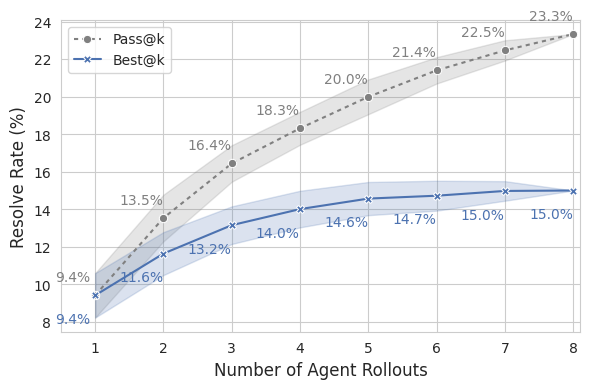

In [35]:
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

PLOT_STD = True
# Create a DataFrame in long format for seaborn
plot_data = []
x = range(1, N+1)
for k, (pass_rate, best_rate) in enumerate(zip(scores['pass_at_n_mean'], scores['best_of_n_mean']), 1):
    plot_data.append({
        'k': k,
        'Rate': pass_rate,
        'Error': scores['pass_at_n_std'][k-1] if PLOT_STD else 0,
        'Metric': 'Pass@k',
        'Lower': pass_rate - (scores['pass_at_n_std'][k-1] if PLOT_STD else 0),
        'Upper': pass_rate + (scores['pass_at_n_std'][k-1] if PLOT_STD else 0)
    })
    plot_data.append({
        'k': k,
        'Rate': best_rate,
        'Error': scores['best_of_n_std'][k-1] if PLOT_STD else 0,
        'Metric': 'Best@k',
        'Lower': best_rate - (scores['best_of_n_std'][k-1] if PLOT_STD else 0),
        'Upper': best_rate + (scores['best_of_n_std'][k-1] if PLOT_STD else 0)
    })

df_plot = pd.DataFrame(plot_data)

# Set the style
sns.set_style("whitegrid")

# Define colors
GRAY_COLOR = "#808080"
BLUE_COLOR = sns.color_palette("deep")[0]  # Seaborn's default blue
colors = {
    'Pass@k': GRAY_COLOR,
    'Best@k': BLUE_COLOR
}

plt.figure(figsize=(6, 4))

# Create the plot
sns.lineplot(
    data=df_plot,
    x='k',
    y='Rate',
    hue='Metric',
    style='Metric',
    markers=True,
    dashes=[(2,2), ()],
    palette=colors
)

# Add error bands
if PLOT_STD:
    for metric, color in colors.items():
        metric_data = df_plot[df_plot['Metric'] == metric]
        plt.fill_between(
            metric_data['k'],
            metric_data['Lower'],
            metric_data['Upper'],
            alpha=0.2,
            color=color
        )

# Add value labels
for metric, color in colors.items():
    metric_data = df_plot[df_plot['Metric'] == metric]
    for _, row in metric_data.iterrows():
        plt.annotate(
            f'{row["Rate"]:.1f}%',
            (row['k'], row['Rate']),
            textcoords="offset points",
            xytext=(-16, 10 if metric == 'Pass@k' else -20),
            ha='center',
            color=color
        )


# Customize plot
plt.xlabel('Number of Agent Rollouts', fontsize=12)
plt.ylabel('Resolve Rate (%)', fontsize=12)
plt.xlim(0.5, N + 0.1)
plt.xticks(x)

# Improve legend
plt.legend(title=None, loc='upper left')

plt.tight_layout()
plt.savefig("7b-moatless-orm.pdf", bbox_inches='tight', dpi=300)
plt.show()